In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
objects_partitions = pd.read_parquet('../../../../../data_acquisition/ztf_forced_photometry/preprocessed/partitions/241209_ndetge8/partitions.parquet')
partitions_test = objects_partitions[objects_partitions['partition'] == 'test'].set_index('oid')
partitions_test

,ra,dec,submitter,class_name,partition
oid,,,,,
ZTF17aaazlzl,120.870621,33.462329,amunoz,AGN,test
ZTF22aaaokdq,219.567335,-6.972391,amunoz,AGN,test
ZTF22aaplgna,188.056342,53.776541,amunoz,AGN,test
ZTF22aboawka,85.887358,-27.651368,amunoz,AGN,test
ZTF22abuhxen,7.403244,-17.641729,amunoz,AGN,test
...,...,...,...,...,...
ZTF21aclutgt,83.637554,-5.963146,amunoz,YSO,test
ZTF22aaaftbh,241.747459,-20.551293,amunoz,YSO,test
ZTF22aafvuwd,240.219609,-25.395348,amunoz,YSO,test


In [3]:
y_test = partitions_test['class_name'].values
y_test

array(['AGN', 'AGN', 'AGN', ..., 'YSO', 'YSO', 'YSO'], dtype=object)

In [7]:
list_time_eval = ['8', '16', '32', '64', '128', '256', '512', '1024', 'None']

path_prod_16 = f'HBRF_20250219-005312'
path_best_16 = f'HBRF_20250304-234653'
path_best_8 = f'HBRF_20250304-225053/trial_19'

num_folds = 5

results = {
    "Production": [],
    "Production_std": [],
    "Best HP (16 days)": [],
    "Best HP (16 days)_std": [],
    "Best HP (8 days)": [],
    "Best HP (8 days)_std": []
}

# Iterate over finished trials
for time_eval in list_time_eval:
    f1_scores_prod_16 = []
    f1_scores_best_16 = []
    f1_scores_best_8 = []

    for fold in range(num_folds):
        prod_16 = pd.read_parquet(f'{path_prod_16}/fold_{fold}/predictions_test_a.parquet')
        best_16 = pd.read_parquet(f'{path_best_16}/fold_{fold}/predictions_test_a.parquet')
        best_8 = pd.read_parquet(f'{path_best_8}/fold_{fold}/predictions_test.parquet')

        # Filtrar por time_eval y reindexar (CORRECTO)
        prod_16 = prod_16[prod_16['shorten'] == time_eval]
        prod_16.index = prod_16.index.astype(str).str.split('_').str[1]
        #print(prod_16.shorten.unique())
        prod_16 = prod_16.reindex(partitions_test.index)

        best_16 = best_16[best_16['shorten'] == time_eval]
        best_16.index = best_16.index.astype(str).str.split('_').str[1]
        best_16 = best_16.reindex(partitions_test.index)
        #print(best_16.shorten.unique())

        best_8 = best_8[best_8['shorten'] == time_eval]
        best_8.index = best_8.index.astype(str).str.split('_').str[1]
        best_8 = best_8.reindex(partitions_test.index)
        #print(best_8.shorten.unique())

        # Obtener las predicciones
        y_pred_prod_16 = prod_16['y_pred'].values
        y_pred_best_16 = best_16['y_pred'].values
        y_pred_best_8 = best_8['y_pred'].values

        # Calcular F1-score para cada modelo en este fold
        f1_scores_prod_16.append(f1_score(y_test, y_pred_prod_16, average="macro"))
        f1_scores_best_16.append(f1_score(y_test, y_pred_best_16, average="macro"))
        f1_scores_best_8.append(f1_score(y_test, y_pred_best_8, average="macro"))

    # Promediar los F1-scores de los folds para cada modelo
    results["Production"].append(np.mean(f1_scores_prod_16))
    results["Production_std"].append(np.std(f1_scores_prod_16))
    results["Best HP (16 days)"].append(np.mean(f1_scores_best_16))
    results["Best HP (16 days)_std"].append(np.std(f1_scores_best_16))
    results["Best HP (8 days)"].append(np.mean(f1_scores_best_8))
    results["Best HP (8 days)_std"].append(np.std(f1_scores_best_8))

# Convertir los resultados a DataFrame para visualización
df_results = pd.DataFrame(results, index=list_time_eval)
df_results

,Production,Production_std,Best HP (16 days),Best HP (16 days)_std,Best HP (8 days),Best HP (8 days)_std
8,0.427091,0.003232,0.471269,0.002038,0.521105,0.002587
16,0.524803,0.001265,0.560177,0.005242,0.575716,0.002199
32,0.620575,0.002280,0.646747,0.003936,0.650520,0.004246
64,0.666576,0.003255,0.685227,0.001673,0.686988,0.002930
128,0.681019,0.002373,0.700788,0.003731,0.700569,0.002543
256,0.687213,0.001566,0.709007,0.004625,0.708937,0.003852
512,0.700796,0.002605,0.722190,0.004980,0.722019,0.003659
1024,0.704213,0.003248,0.728416,0.003612,0.727175,0.004357
None,0.703543,0.003907,0.726859,0.003967,0.727251,0.003605


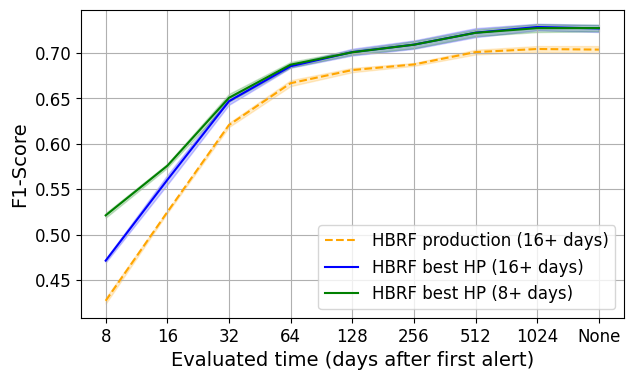

In [8]:
import matplotlib.pyplot as plt

# Graficar los resultados con bandas de error
plt.figure(figsize=(7, 4))

plt.plot(df_results.index, df_results["Production"], label="HBRF production (16+ days)", linestyle="--", color="orange")
plt.fill_between(df_results.index, 
                 df_results["Production"] - df_results["Production_std"], 
                 df_results["Production"] + df_results["Production_std"], 
                 alpha=0.2, color="orange")

plt.plot(df_results.index, df_results["Best HP (16 days)"], label="HBRF best HP (16+ days)", linestyle="-", color="blue")
plt.fill_between(df_results.index, 
                 df_results["Best HP (16 days)"] - df_results["Best HP (16 days)_std"], 
                 df_results["Best HP (16 days)"] + df_results["Best HP (16 days)_std"], 
                 alpha=0.2, color="blue")

plt.plot(df_results.index, df_results["Best HP (8 days)"], label="HBRF best HP (8+ days)", linestyle="-", color="green")
plt.fill_between(df_results.index, 
                 df_results["Best HP (8 days)"] - df_results["Best HP (8 days)_std"], 
                 df_results["Best HP (8 days)"] + df_results["Best HP (8 days)_std"], 
                 alpha=0.2, color="green")

# Ajustar tamaños de las etiquetas y ticks
plt.xlabel("Evaluated time (days after first alert)", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()
